In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(178)

# Simulate data
num_observations = 1000

# Covariates
ages = np.random.randint(18, 65, size=num_observations)  # Age between 18 and 65
regions = np.random.choice(['urban', 'suburban', 'rural'], size=num_observations)  # Region
policy_types = np.random.choice(['basic', 'premium', 'vip'], size=num_observations)  # Policy type

# Assign numeric codes to categorical variables
region_codes = pd.Categorical(regions).codes  # Convert to integers (0, 1, 2)
policy_type_codes = pd.Categorical(policy_types).codes  # Convert to integers (0, 1, 2)

# Simulate claim frequency using Poisson distribution with covariates
claim_frequency = np.random.poisson(
    lam=1 + 0.03 * ages + 0.5 * policy_type_codes - 0.2 * region_codes, 
    size=num_observations
)

# Simulate claim severity using Gamma distribution with covariates
claim_severity = np.random.gamma(
    shape=2, 
    scale=1000 + 50 * policy_type_codes - 20 * region_codes, 
    size=num_observations
)

# Calculate total claims
total_claims = claim_frequency * claim_severity
# Create a DataFrame
claims_data = pd.DataFrame({
    'Frequency': claim_frequency,
    'Severity': claim_severity,
    'TotalClaims': total_claims,
    'Age': ages,
    'Region': regions,
    'PolicyType': policy_types
})

# Display the data
print(claims_data.head())

   Frequency     Severity   TotalClaims  Age    Region PolicyType
0          3  1382.780580   4148.341740   47     urban    premium
1          1  4359.307875   4359.307875   21  suburban    premium
2          1   749.978073    749.978073   33     urban      basic
3          2  5425.595960  10851.191921   46     urban      basic
4          5  5193.760300  25968.801498   62  suburban    premium


In [2]:
# GLM for claim frequency with covariates (Poisson regression)
freq_model_with_covariates = smf.glm(
    'Frequency ~ Age + Region + PolicyType', 
    family=sm.families.Poisson(), 
    data=claims_data
).fit()

print(freq_model_with_covariates.summary())

# GLM for claim severity with covariates (Gamma regression)
log_link = sm.families.links.log()  # Log link for Gamma regression
sev_model_with_covariates = smf.glm(
    'Severity ~ Age + Region + PolicyType', 
    family=sm.families.Gamma(link=log_link), 
    data=claims_data
).fit()

print(sev_model_with_covariates.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Frequency   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      994
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1814.6
Date:                Wed, 18 Dec 2024   Deviance:                       1128.1
Time:                        07:03:42   Pearson chi2:                     997.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1811
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.17

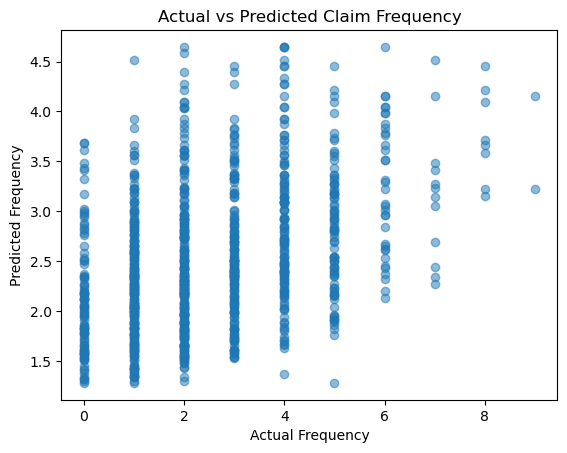

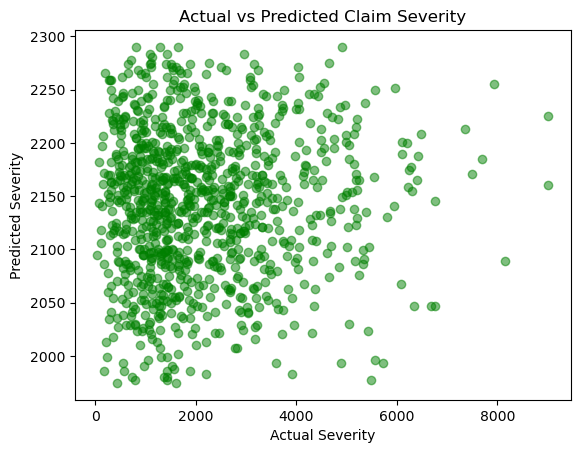

In [3]:
# Plot actual vs. predicted claim frequencies
claims_data['PredictedFrequency'] = freq_model_with_covariates.predict()
plt.scatter(claims_data['Frequency'], claims_data['PredictedFrequency'], alpha=0.5)
plt.xlabel('Actual Frequency')
plt.ylabel('Predicted Frequency')
plt.title('Actual vs Predicted Claim Frequency')
plt.show()

# Plot actual vs. predicted claim severities
claims_data['PredictedSeverity'] = sev_model_with_covariates.predict()
plt.scatter(claims_data['Severity'], claims_data['PredictedSeverity'], alpha=0.5, color='green')
plt.xlabel('Actual Severity')
plt.ylabel('Predicted Severity')
plt.title('Actual vs Predicted Claim Severity')
plt.show()


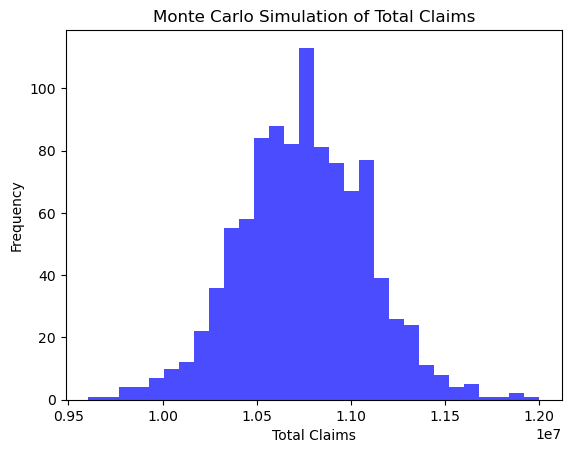

In [4]:
# Monte Carlo Simulation for total claims
num_simulations = 1000
simulated_claims = [
    np.sum(
        np.random.poisson(
            lam=freq_model_with_covariates.predict(claims_data), 
            size=num_observations
        ) * 
        np.random.gamma(
            shape=2, 
            scale=claims_data['PredictedSeverity'], 
            size=num_observations
        )
    )
    for _ in range(num_simulations)
]

# Convert the results to a DataFrame
simulation_results = pd.DataFrame({'SimulatedTotalClaims': simulated_claims})

# Plot the distribution of total claims
plt.hist(simulation_results['SimulatedTotalClaims'], bins=30, color='blue', alpha=0.7)
plt.xlabel('Total Claims')
plt.ylabel('Frequency')
plt.title('Monte Carlo Simulation of Total Claims')
plt.show()

In [6]:
print(simulation_results.summary())

AttributeError: 'DataFrame' object has no attribute 'summary'